# Chemical Space Networks Based on Maximum Common Substructure

**V.F. Scalfani, V.D. Patel, and A.M. Fernandez** \
v. October 19, 2022

*w/ glucocorticoid_receptor_2034_2.csv dataset*

## 1. Import RDKit, Networkx, and other libraries

In [1]:
# RDKit stuff
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFMCS
from rdkit import DataStructs

# numpy
import numpy as np

# pandas
import pandas as pd

# networkx
import networkx as nx

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Print versions of libraries used
print('RDKit version: ',rdBase.rdkitVersion)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Networkx version',nx.__version__)
print('MatplotLib version:', mpl.__version__)

RDKit version:  2022.03.5
Numpy version: 1.23.3
Pandas version: 1.4.4
Networkx version 2.8.6
MatplotLib version: 3.5.3


# 2. Load Data

In [3]:
# load the subsets data
import pickle
with open('subsets.pickle', 'rb') as infile:
    subsets = pickle.load(infile)

In [4]:
list(subsets.values())[0:5]

[{'smi1': 'CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C',
  'smi2': 'COc1ccc2c(c1)-c1ccc3c(c1[C@H](c1ccccc1)O2)C(C)=CC(C)(C)N3',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7f6c4553d850>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7f6c4553d940>,
  'tan_similarity': 0.155,
  'tan_mcs': 0.475},
 {'smi1': 'CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C',
  'smi2': 'C#COc1ccc2c(c1OC)-c1ccc3c(c1[C@H](CC=C)O2)C(C)=CC(C)(C)N3',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7f6c4553d9e0>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7f6c4553da80>,
  'tan_similarity': 0.16,
  'tan_mcs': 0.45},
 {'smi1': 'CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C',
  'smi2': 'CC#C[C@@]1(O)CC[C@@]2(Cc3ccccc3)c3ccc(C(=O)NCc4ccncc4)cc3CC[C@@H]2C1',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7f6c4553db20>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7f6c4553dbc0>,
  'tan_similarity': 0.175,
  'tan_mcs': 0.444},
 {'smi1': 'CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C',
  'smi2'

In [5]:
# load the node data
with open('node_data.pickle', 'rb') as infile:
    node_data = pickle.load(infile)

In [6]:
list(node_data.keys())[0:5]

['CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C',
 'COc1ccc2c(c1)-c1ccc3c(c1[C@H](c1ccccc1)O2)C(C)=CC(C)(C)N3',
 'C#COc1ccc2c(c1OC)-c1ccc3c(c1[C@H](CC=C)O2)C(C)=CC(C)(C)N3',
 'CC#C[C@@]1(O)CC[C@@]2(Cc3ccccc3)c3ccc(C(=O)NCc4ccncc4)cc3CC[C@@H]2C1',
 'C=CC[C@@H]1Oc2ccc(OC#N)c(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3']

In [7]:
list(node_data.values())[0:5]

[{'Molecule ChEMBL ID': 'CHEMBL103', 'pKi': 7.515700160653214},
 {'Molecule ChEMBL ID': 'CHEMBL1089811', 'pKi': 7.7447274948966935},
 {'Molecule ChEMBL ID': 'CHEMBL1089812', 'pKi': 8.3767507096021},
 {'Molecule ChEMBL ID': 'CHEMBL1090477', 'pKi': 8.698970004336019},
 {'Molecule ChEMBL ID': 'CHEMBL1090801', 'pKi': 7.292429823902063}]

# 3. Create CSN based on Maximum Common Substructure-based Similarity

In [8]:
# total number of possible edges
len(subsets)

81406

In [9]:
# We will try and match the number of edges for the MCS CSN to the tanimoto similarity CSN example
# See Zhang, B. et al. J Comput Aided Mol Des 2015, 29 (10), 937–950. https://doi.org/10.1007/s10822-015-9872-1.

# In our example: >= 0.68 tanimoto similarity, edges = 7739, edge_density = 0.095

# loop through and find a suitable similarity value for MCS that gets about 7700 edges
mcs_range = np.linspace(0,1,201) # get a range of numbers for 0 to 1, by 0.05
subsets_filtered_mcs = {}
for similarity_mcs in mcs_range:
    subsets_filtered_mcs = {key: value for key, value in subsets.items() if value['tan_mcs'] >= similarity_mcs}
    if 7600 < len(subsets_filtered_mcs) <= 7800:
        print(similarity_mcs)

0.635


In [10]:
subsets_filtered_mcs = {}
subsets_filtered_mcs = {key: value for key, value in subsets.items() if value['tan_mcs'] >= 0.635}
len(subsets_filtered_mcs) # equals number of edges

7709

In [11]:
# Edge density (number of edges / number of total edges)
# Defined in: Zhang, B. et al.J Comput Aided Mol Des 2015, 29 (10), 937–950. 
# https://doi.org/10.1007/s10822-015-9872-1.

edge_density_mcs = round((len(subsets_filtered_mcs) / len(subsets)),3)
edge_density_mcs

0.095

In [12]:
# create a list of SMILES that will be nodes from the edges
smi1_filtered_mcs = []
smi2_filtered_mcs = []
for key,value in subsets_filtered_mcs.items():
    smi1_filtered_mcs.append(value['smi1'])
    smi2_filtered_mcs.append(value['smi2'])
    
# combine the 2 lists
smi12_filtered_mcs = smi1_filtered_mcs + smi2_filtered_mcs

# get unique
smi12_filtered_set = set(smi12_filtered_mcs)
len(smi12_filtered_set) # of nodes (smiles) in network

398

In [13]:
len(node_data) # original

404

In [14]:
smis = []
for key,value in node_data.items():
    smis.append(key)

In [15]:
# print list of nodes that are not in the filtered list
nodes_to_remove = set(smis) - smi12_filtered_set
nodes_to_remove

{'CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(C(F)(F)F)c1',
 'CCCCC1CCN(CCCC(=O)c2ccccc2C)CC1',
 'C[C@H]1CN(C(=O)Nc2ccc(C(F)(F)F)nc2)[C@H](C)CN1c1ccc(C#N)c(C(F)(F)F)c1',
 'Cc1ccc(C(=O)CC(Nc2ccc([N+](=O)[O-])cc2)c2cccc(F)c2)cc1',
 'Cn1c(=O)[nH]c(N2CCN(c3ccccc3)CC2)c(Cc2ccccc2)c1=O',
 'O=C(Cc1ccccc1)NC1CCN(CCCN2C(=O)COc3ccccc32)CC1'}

In [16]:
# finally, we can remove these from the node data as follows:
# this removes nodes from the graph with no edges
node_data_filtered_mcs = {node: node_data[node] for node in list(smi12_filtered_set)}
len(node_data_filtered_mcs)

398

## Plot MCS Similarity-based CSN as circle nodes

In [17]:
# Create a graph and add edges
G1 = nx.Graph()
for key, value in subsets_filtered_mcs.items():
    G1.add_edge(value['smi1'], value['smi2'], weight=value['tan_mcs'])

In [18]:
# The weights are stored in edge_data:
#for edge in G1.edges(data=True):
#    print(edge)

In [19]:
# Add attributes to nodes
for key,value in node_data_filtered_mcs.items():
    G1.add_node(key, ID=value['Molecule ChEMBL ID'], pKi=value['pKi'])

In [20]:
# view the added node attributes as follows:
# for node in G1.nodes(data=True):
#     print(node[0],node[1]["ID"],node[1]["pKi"])

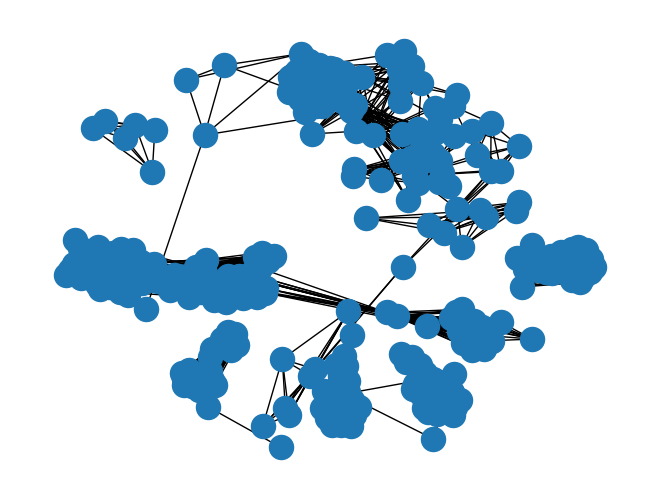

In [21]:
pos = nx.spring_layout(G1, k=0.3,seed=40) # added a seed for layout reproducibility, k is space between nodes
nx.draw(G1,pos)
plt.axis("off")
plt.show()

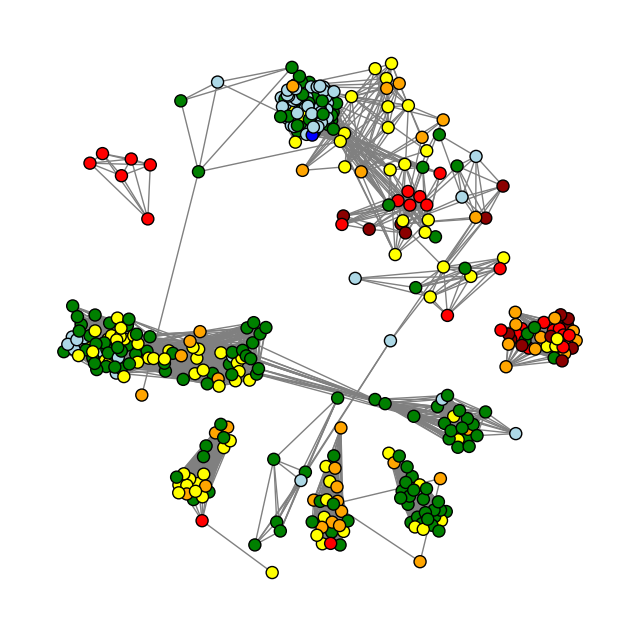

In [22]:
# Add color to nodes based on pKi value and adjust size
# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 4<= node[1]["pKi"] <= 5:
        color_map.append("darkred")
    elif 5 < node[1]["pKi"] <= 6:
        color_map.append("red")
    elif 6 < node[1]["pKi"] <= 7:
        color_map.append("orange")
    elif 7 < node[1]["pKi"] <= 8:
        color_map.append("yellow")
    elif 8 < node[1]["pKi"] <= 9:
        color_map.append("green")
    elif 9 < node[1]["pKi"] <= 10:
        color_map.append("lightblue")
    elif 10 < node[1]["pKi"] <= 11:
        color_map.append("blue")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.3, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")
plt.show()      

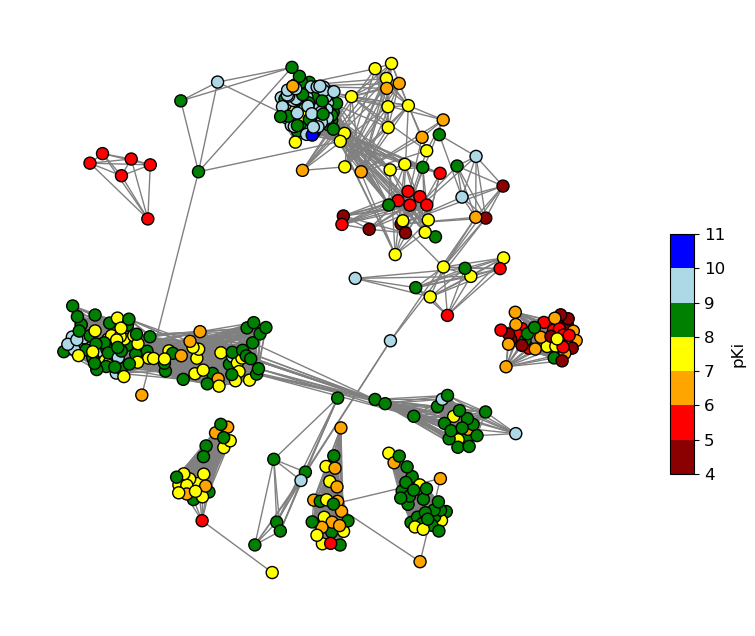

In [23]:
# Add legends

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 4<= node[1]["pKi"] <= 5:
        color_map.append("darkred")
    elif 5 < node[1]["pKi"] <= 6:
        color_map.append("red")
    elif 6 < node[1]["pKi"] <= 7:
        color_map.append("orange")
    elif 7 < node[1]["pKi"] <= 8:
        color_map.append("yellow")
    elif 8 < node[1]["pKi"] <= 9:
        color_map.append("green")
    elif 9 < node[1]["pKi"] <= 10:
        color_map.append("lightblue")
    elif 10 < node[1]["pKi"] <= 11:
        color_map.append("blue")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.3, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)
plt.show()

In [24]:
# Get number of seperate connected components
nx.number_connected_components(G1)

11

In [25]:
# Save a list of the individual connected component graphs
connected_graphs1 = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

In [26]:
len(connected_graphs1)

11

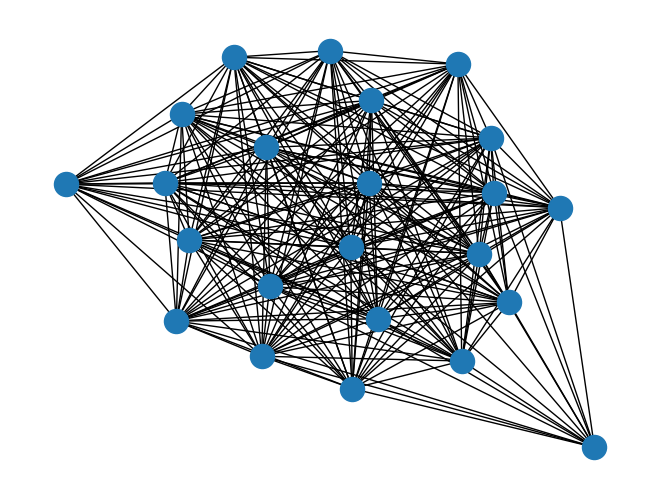

In [27]:
# Let's look one of the subgraphs
H1 = connected_graphs1[1]
pos = nx.spring_layout(H1, seed=30) # added a seed for layout reproducibility
nx.draw(H1,pos)
plt.axis("off")
plt.show()

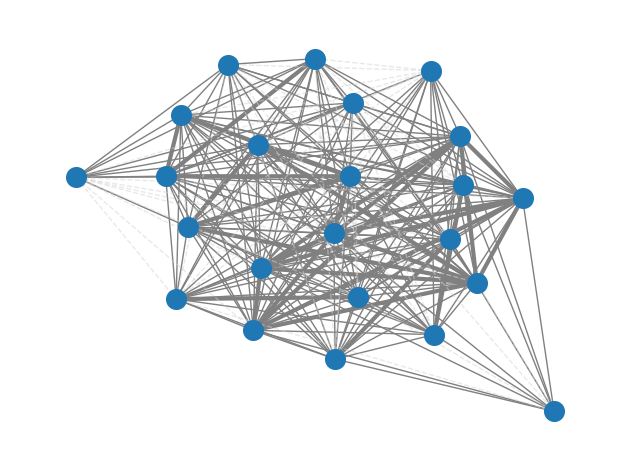

In [28]:
# Let's add in the weights, which would be similarity as line thickness
# Adapted from: https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html?highlight=weighted_graph
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
nx.draw_networkx_nodes(H1, pos, node_size=200)
nx.draw_networkx_edges(H1, pos, edgelist=thick, width=3, edge_color="grey")
nx.draw_networkx_edges(H1, pos, edgelist=medium, width=1, edge_color="grey")
nx.draw_networkx_edges(H1, pos, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

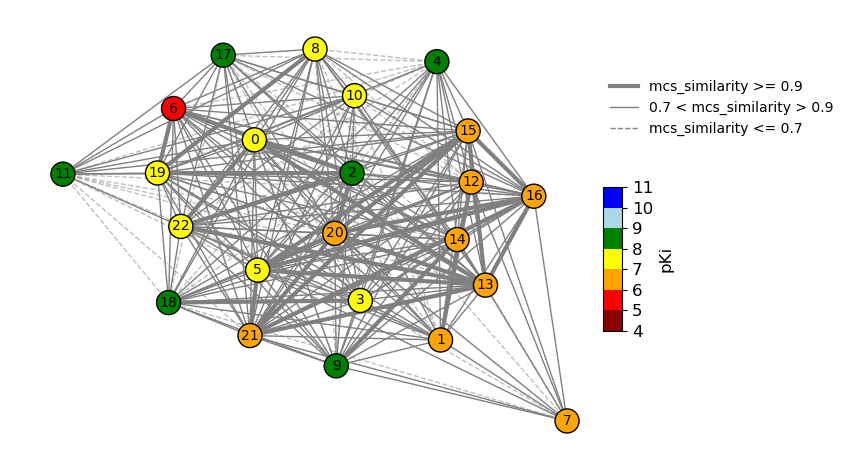

In [29]:
# Next add in the color for the nodes as before and number the nodes
fig, ax = plt.subplots()

# Line weights based on similarity value
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

# Add color based on pKi and node number labels
custom_labels = {}
color_map = []
label_number = 0
for node in H1.nodes(data=True):
    custom_labels[node[0]] = str(label_number)
    label_number+=1
    if 4<= node[1]["pKi"] <= 5:
        color_map.append("darkred")
    elif 5 < node[1]["pKi"] <= 6:
        color_map.append("red")
    elif 6 < node[1]["pKi"] <= 7:
        color_map.append("orange")
    elif 7 < node[1]["pKi"] <= 8:
        color_map.append("yellow")
    elif 8 < node[1]["pKi"] <= 9:
        color_map.append("green")
    elif 9 < node[1]["pKi"] <= 10:
        color_map.append("lightblue")
    elif 10 < node[1]["pKi"] <= 11:
        color_map.append("blue")
    else:
        color_map.append("white")

# plot with weights, node color, and labels.
pos = nx.spring_layout(H1, seed=30)
nx.draw_networkx_nodes(H1, pos, ax=ax, node_size=300, node_color=color_map, edgecolors="black")
nx.draw_networkx_labels(H1, pos, custom_labels, ax=ax, font_size=10, font_color="black")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thick, width=3, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=medium, width=1, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="grey", style="dashed")
ax = plt.gca()
plt.axis("off")
plt.tight_layout()


# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.3, 0.55, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="gray", lw=3),
                Line2D([0], [0], color="grey", lw=1),
                Line2D([0], [0], color="grey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 10}, fancybox=True, framealpha=0)

plt.savefig('Figure-03_MCS_1_node_lines.png', bbox_inches='tight')
plt.show()

In [30]:
custom_labels

{'COc1ccc2c(c1)-c1ccc3c(c1C(c1ccccc1)O2)C(C)=CC(C)(C)N3': '0',
 'CC1=CC(C)(C)Nc2ccc3c(c21)C(C)Oc1ccc(Cl)cc1-3': '1',
 'CC1=CC(C)(C)Nc2ccc3c(c21)C(c1ccccc1)Oc1ccc(Cl)cc1-3': '2',
 'C=CC[C@@H]1Oc2ccc(OC#N)c(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '3',
 'C=CCC1Oc2ccc(C(=O)OC)c(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '4',
 'CCCCC1Oc2ccc(C)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '5',
 'COc1ccc2c(c1)OC(c1ccccc1)c1c-2ccc2c1C(C)=CC(C)(C)N2': '6',
 'CCCOC1Oc2ccc(Cl)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '7',
 'COc1cccc2c1-c1ccc3c(c1C(c1cc(Cl)cc(Cl)c1)O2)C(C)=CC(C)(C)N3': '8',
 'C#Cc1cccc2c1-c1ccc3c(c1[C@H](CC=C)O2)C(C)=CC(C)(C)N3': '9',
 'COc1cccc2c1-c1ccc3c(c1C(c1cccc(C(F)(F)F)c1)O2)C(C)=CC(C)(C)N3': '10',
 'COc1cccc2c1-c1ccc3c(c1C(c1cccc(OC(=O)N(C)C)c1)O2)C(C)=CC(C)(C)N3': '11',
 'CC1=CC(C)(C)Nc2ccc3c(c21)C(C)Oc1ccc(F)cc1-3': '12',
 'CCCCC1Oc2ccc(OC)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '13',
 'C=CCC1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '14',
 'CCCCC1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)(C)N3': '15',
 'CCCCC1Oc2ccc(F

In [31]:
# add the node data to a dataframe
columns = ("Smiles", "ID","pKi")
index = tuple(custom_labels.values())
table_data = []
#label_number = 0
for node in H1.nodes(data=True):
    Smiles = node[0]
    id_value = node[1]["ID"]
    Ki = node[1]["pKi"]
    table_data.append([Smiles, id_value, Ki])
#    label_number += 1
df_H1 = pd.DataFrame(table_data, columns = columns, index=index)
print(df_H1)

                                               Smiles             ID       pKi
0   COc1ccc2c(c1)-c1ccc3c(c1C(c1ccccc1)O2)C(C)=CC(...   CHEMBL317983  7.744727
1        CC1=CC(C)(C)Nc2ccc3c(c21)C(C)Oc1ccc(Cl)cc1-3   CHEMBL286446  6.435334
2   CC1=CC(C)(C)Nc2ccc3c(c21)C(c1ccccc1)Oc1ccc(Cl)...   CHEMBL318409  8.031517
3   C=CC[C@@H]1Oc2ccc(OC#N)c(OC)c2-c2ccc3c(c21)C(C...  CHEMBL1090801  7.292430
4   C=CCC1Oc2ccc(C(=O)OC)c(OC)c2-c2ccc3c(c21)C(C)=...     CHEMBL7843  8.552842
5      CCCCC1Oc2ccc(C)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3   CHEMBL114941  7.292430
6   COc1ccc2c(c1)OC(c1ccccc1)c1c-2ccc2c1C(C)=CC(C)...    CHEMBL99128  5.744727
7     CCCOC1Oc2ccc(Cl)cc2-c2ccc3c(c21)C(C)=CC(C)(C)N3   CHEMBL116221  6.585027
8   COc1cccc2c1-c1ccc3c(c1C(c1cc(Cl)cc(Cl)c1)O2)C(...   CHEMBL419158  7.454281
9   C#Cc1cccc2c1-c1ccc3c(c1[C@H](CC=C)O2)C(C)=CC(C...  CHEMBL1090805  8.161151
10  COc1cccc2c1-c1ccc3c(c1C(c1cccc(C(F)(F)F)c1)O2)...    CHEMBL95644  7.958607
11  COc1cccc2c1-c1ccc3c(c1C(c1cccc(OC(=O)N(C)C)c1)..

## Plot MCS Similarity-based CSN with 2D Structure Depictions as Nodes

In [32]:
# png function to view molecules
import io
from PIL import Image
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

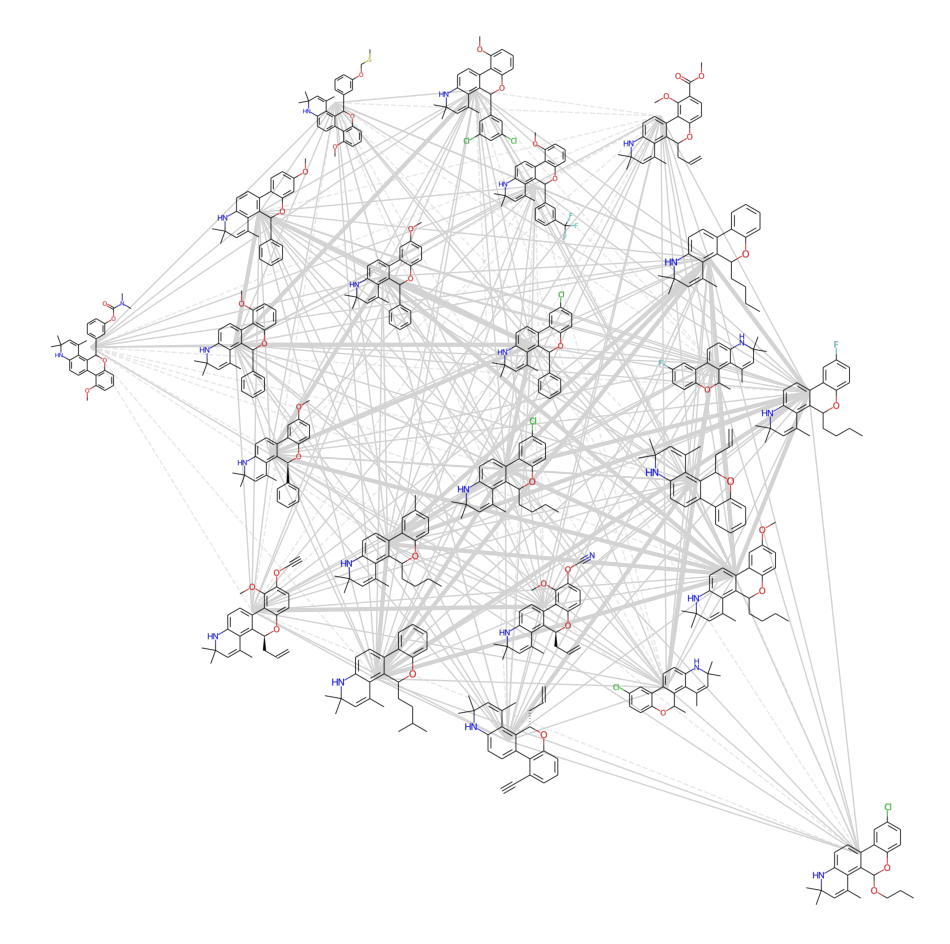

In [36]:
# now let's create a basic plot with the molecule images and line weights:
# Adapted from: https://networkx.org/documentation/stable/auto_examples/drawing/plot_custom_node_icons.html
# and https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html?highlight=weighted_graph
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.045 # adjust this value to change size of structure drawings
struct_center = struct_size / 2.0

# Add the respective image to each node
for smi in H1.nodes:
    
    # draw molecule
    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().clearBackground = False
    drawer.drawOptions().addStereoAnnotation = False
    drawer.DrawMolecule(Chem.MolFromSmiles(smi))
    drawer.FinishDrawing()
    mol = drawer.GetDrawingText()
         
    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot structure
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(mol))
    a.axis("off")
plt.savefig('Figure-04_MCS_1_structures_basic.png', bbox_inches='tight')  
plt.show()

In [37]:
# Next we can add color to the molecules with highlighting
# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html
# get some rgba values
from matplotlib import colors
print(colors.to_rgba('darkred'))
print(colors.to_rgba('red'))
print(colors.to_rgba('orange'))
print(colors.to_rgba('yellow'))
print(colors.to_rgba('green'))
print(colors.to_rgba('lightblue'))
print(colors.to_rgba('blue'))
print(colors.to_rgba('white'))

(0.5450980392156862, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 1.0)
(1.0, 0.6470588235294118, 0.0, 1.0)
(1.0, 1.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)
(0.6784313725490196, 0.8470588235294118, 0.9019607843137255, 1.0)
(0.0, 0.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


In [38]:
# define a function that highlights the molecule with the colors
# adjusted alpha values to make transparent
def highlight_mol(smi,label,color):
    
    mol = Chem.MolFromSmiles(smi)
    
    if color == 'darkred':
        rgba = (0.55, 0.0, 0.0, 0.3)       
    elif color == 'red':
        rgba = (1.0, 0.0, 0.0, 0.2)    
    elif color == 'orange':
        rgba = (1.0, 0.65, 0.0, 0.2)        
    elif color == 'yellow':
        rgba = (1.0, 1.0, 0.0, 0.4)        
    elif color == 'green':
        rgba = (0.0, 0.50, 0.0, 0.15)        
    elif color == 'lightblue':
        rgba = (0.68, 0.85, 0.90, 0.5)   
    elif color == 'blue':
        rgba = (0.0, 0.0, 1.0, 0.1)    
    else: # no color
        rgba = (1,1,1,1) 
             
    atoms = []
    for a in mol.GetAtoms():
        atoms.append(a.GetIdx())
    
    bonds = []
    for bond in mol.GetBonds():
        aid1 = atoms[bond.GetBeginAtomIdx()]
        aid2 = atoms[bond.GetEndAtomIdx()]
        bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=15
    drawer.drawOptions().legendFontSize=60
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, legend=label,highlightAtoms=atoms, highlightBonds=bonds)
    
    mol_png = drawer.GetDrawingText()
    return mol_png

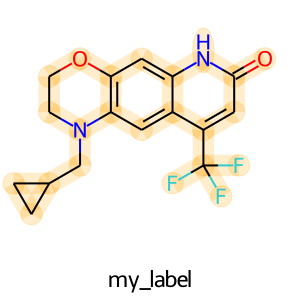

In [39]:
show_png(highlight_mol('O=c1cc(C(F)(F)F)c2cc3c(cc2[nH]1)OCCN3CC1CC1','my_label', 'orange'))

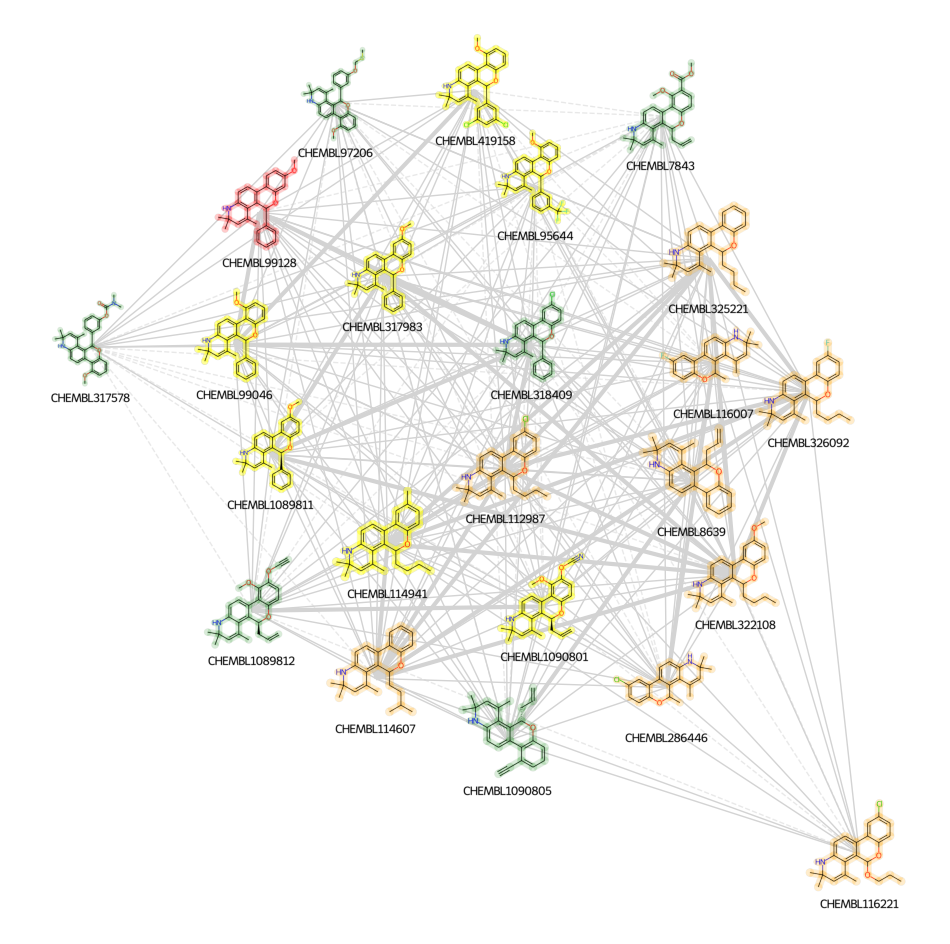

In [42]:
# Now add in color to molecules
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():

    if 4<= value["pKi"] <= 5:
        highlight_color = "darkred"
        
    elif 5 < value["pKi"] <= 6:
        highlight_color = "red"
        
    elif 6 < value["pKi"] <= 7:
        highlight_color ="orange"
        
    elif 7 < value["pKi"] <= 8:
        highlight_color = "yellow"
        
    elif 8 < value["pKi"] <= 9:
        highlight_color = "green"
        
    elif 9 < value["pKi"] <= 10:
        highlight_color = "lightblue"
        
    elif 10 < value["pKi"] <= 11:
        highlight_color = "blue"
    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,value["ID"], highlight_color)))
    a.axis("off")
         
plt.show()


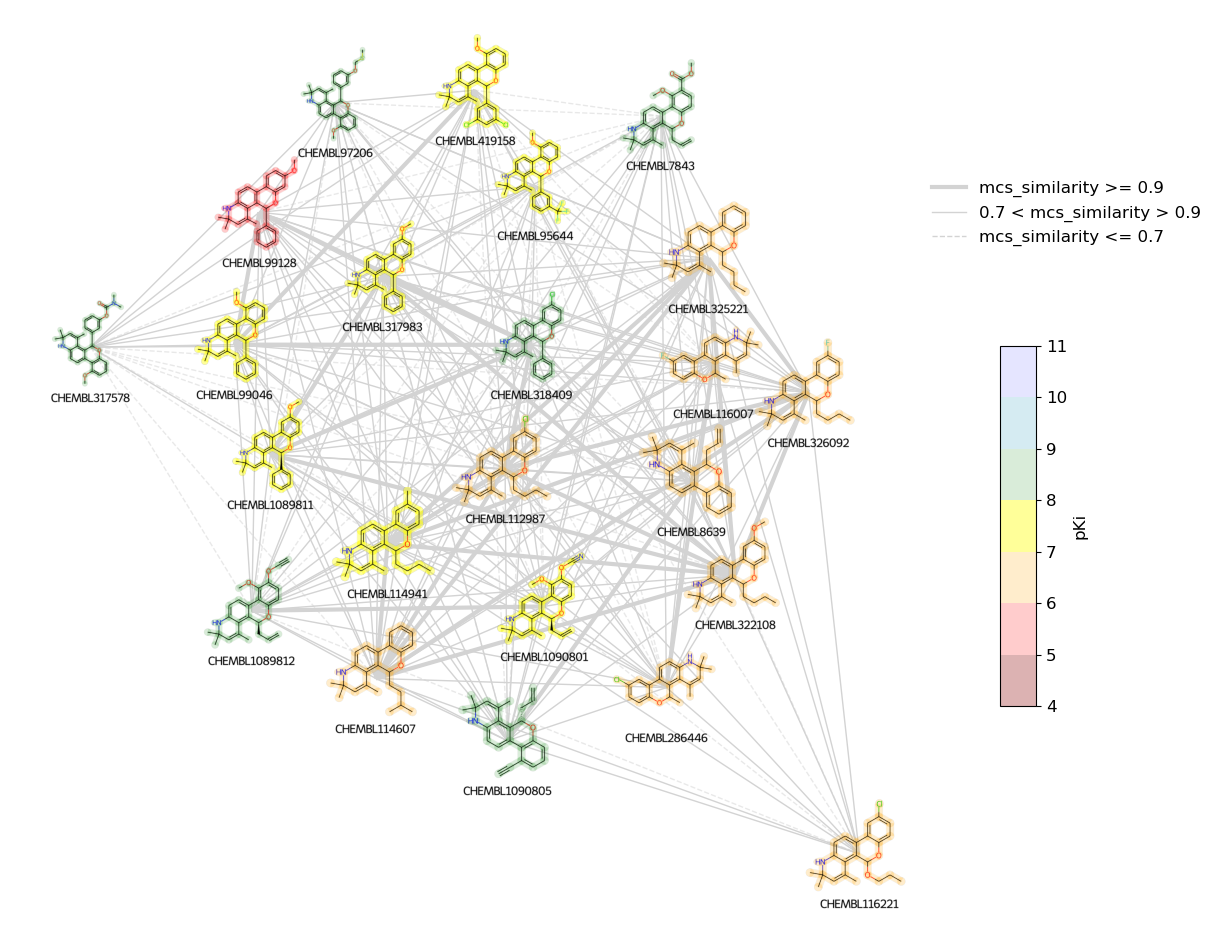

In [60]:
# Finally, add some legends
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():

    if 4<= value["pKi"] <= 5:
        highlight_color = "darkred"
        
    elif 5 < value["pKi"] <= 6:
        highlight_color = "red"
        
    elif 6 < value["pKi"] <= 7:
        highlight_color ="orange"
        
    elif 7 < value["pKi"] <= 8:
        highlight_color = "yellow"
        
    elif 8 < value["pKi"] <= 9:
        highlight_color = "green"
        
    elif 9 < value["pKi"] <= 10:
        highlight_color = "lightblue"
        
    elif 10 < value["pKi"] <= 11:
        highlight_color = "blue"
    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,value["ID"], highlight_color)))
    a.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html
ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,
                               yellow_bar,green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.1, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.savefig('Figure-05_MCS_1_structures_advanced.png',  bbox_inches='tight')
plt.show()

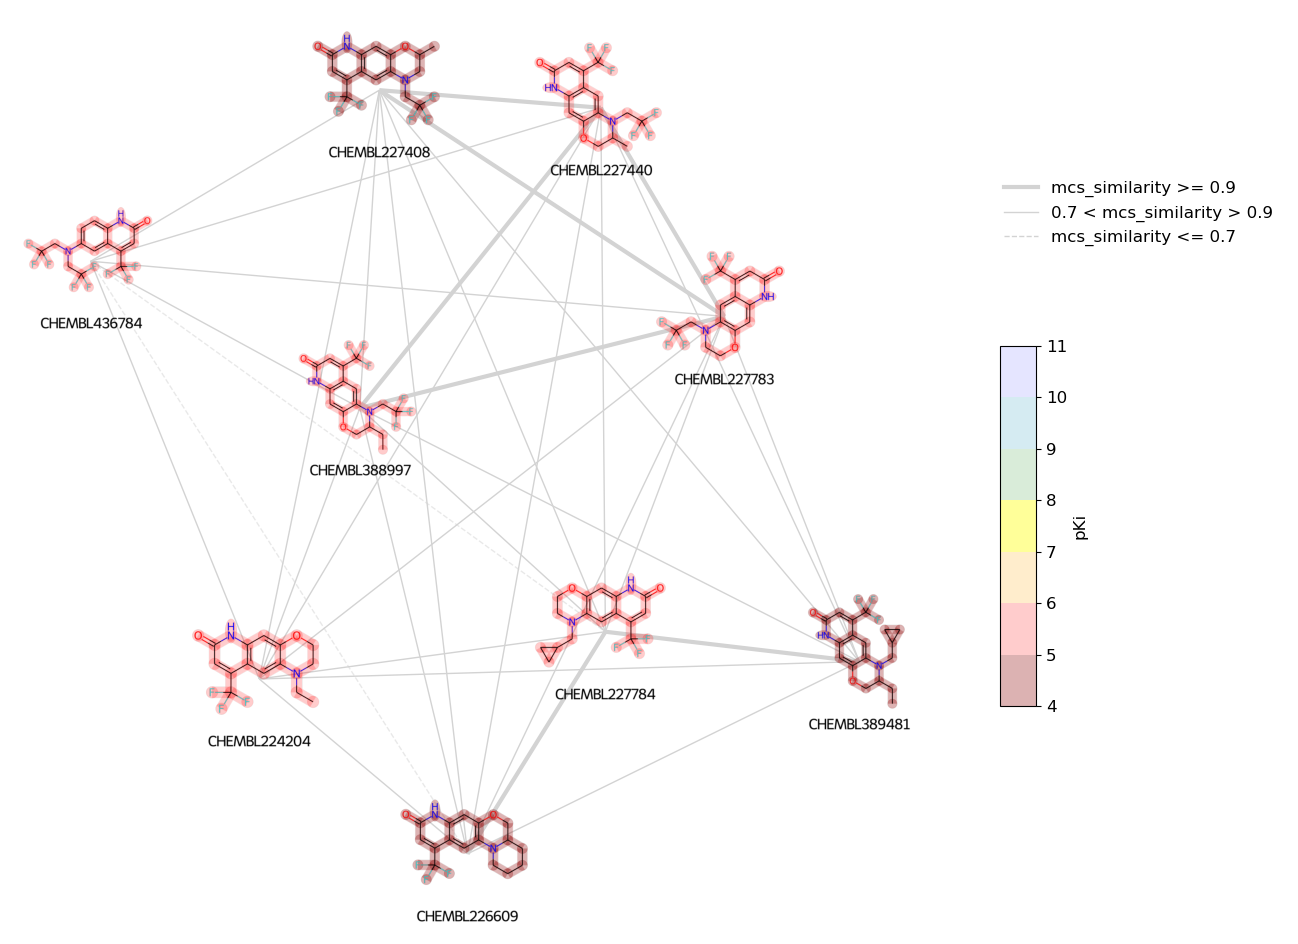

In [49]:
# Let's look at one more, with a different connected graph
H2 = connected_graphs1[4]

thick = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H2.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H2, seed=40)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H2.nodes.items():

    if 4<= value["pKi"] <= 5:
        highlight_color = "darkred"
        
    elif 5 < value["pKi"] <= 6:
        highlight_color = "red"
        
    elif 6 < value["pKi"] <= 7:
        highlight_color ="orange"
        
    elif 7 < value["pKi"] <= 8:
        highlight_color = "yellow"
        
    elif 8 < value["pKi"] <= 9:
        highlight_color = "green"
        
    elif 9 < value["pKi"] <= 10:
        highlight_color = "lightblue"
        
    elif 10 < value["pKi"] <= 11:
        highlight_color = "blue"
    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,value["ID"], highlight_color)))
    a.axis("off")

# add legends

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,yellow_bar,
                               green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.16, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.show()

# 4. Compute Some Network Properties

## Clustering Coefficient

In [22]:
node_coefficients = nx.clustering(G1, weight="weight")

# Get mean 
coefficients = []
for key,value in node_coefficients.items():
    coefficients.append(value)
    
avg_clustering_coefficient = np.mean(coefficients)
round(avg_clustering_coefficient,3)

0.708

In [23]:
# This also works:
round(nx.average_clustering(G1,weight="weight"),3)

0.708

## Degree Assortativity

In [24]:
round(nx.degree_assortativity_coefficient(G1,weight="weight"),3)

0.838

## Communities

In [25]:
# using the greedy_modularity_communities as an example
# There are many others, see the NetworkX docs

from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G1, weight="weight") # added in similarity threshold as a weight

In [26]:
len(communities)

13

In [27]:
# create a list of colors from a matplotlib colormap
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20')

color_intervals = np.linspace(0,1,13) # for 13 colors
colors_tab = []
for value in color_intervals:
    colors_tab.append(cmap(value))

In [28]:
# add color to nodes by community group
community_color_map = []
for node in G1.nodes:
     for idx,community in enumerate(communities):
        if node in community:
            #print(node,idx)
            community_color_map.append(colors_tab[idx])

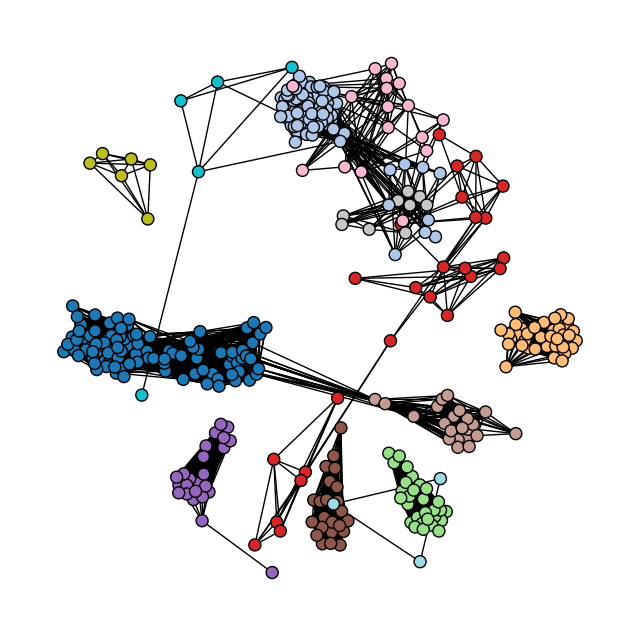

In [29]:
# plot nodes with color as community
pos = nx.spring_layout(G1, k=0.3, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G1,pos, node_color=community_color_map, edgecolors="black", node_size=75)
plt.axis("off")
plt.savefig("Figure-06--mcs_communities.png", bbox_inches='tight')
plt.show()  # how cool is that!

## Modularity

In [30]:
import networkx.algorithms.community as nx_comm
round(nx_comm.modularity(G1,communities),3)

0.706